In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

In [2]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download the training data
trainset = datasets.MNIST('data', download = True, train = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 128, shuffle = True)

# Download the test data 
testset = datasets.MNIST('data', download = True, train = False, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 5000, shuffle = True)

torch.Size([128, 1, 28, 28])


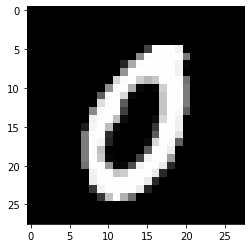

In [3]:
images, labels = next(iter(trainloader))
print(images.shape)
plt.imshow(images[0].numpy().squeeze(), cmap='Greys_r')
plt.show()

## Network Arquitecture


In [4]:
from torch import nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 16, 5, padding = 2) # 28x28x1 * (5x5x1)x16 = 28x28x16
        self.maxpool1 = nn.MaxPool2d(2, 2) # 28x28x16 * (2,2) = 14x14x16
        self.conv2 = nn.Conv2d(16, 32, 5, padding = 2) # 14x14x16 * (5,5,16)x32 = 14x14x32
        self.maxpool2 = nn.MaxPool2d(2, 2) # 14x14x32 * (2,2) = 7x7x32
        
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        
        # first cnn
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        
        # second cnn
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        
        # flatten output 
        x = x.view(x.size(0),-1)
        
        # fully connected
        x = self.fc(x)
        
        return x

In [5]:
model = CNN()
model

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)

## Training CNN

In [6]:
from torch import optim
learning_rate=0.1

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [7]:
epochs = 3

losses = []

for epoch in range(epochs):
    train_loss = 0 
    test_loss = 0
    
    # Train
    for images, labels in trainloader:
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    losses.append(train_loss/len(trainloader))
    
    correct = 0
    
    # Valid test
    for images_test, labels_test in testloader:
        
        output = model(images_test)
        loss = criterion(output, labels_test)
        test_loss += loss.item()
        
        _, yhat = torch.max(output, 1)
        correct += (yhat == labels_test).sum().item()
        
    accuracy = correct / len(testset)
    
    # Prints
    print('Epoch: {}/{} \tTrain loss:{:.3} \tTest loss:{:.3}'.format(epoch+1, epochs, train_loss/len(trainloader), 
                                                                      test_loss/len(testloader)))
print('\nGlobal accuracy: {:.1%}'.format(accuracy))   

Epoch: 1/3 	Train loss:0.229 	Test loss:0.0689
Epoch: 2/3 	Train loss:0.0663 	Test loss:0.0462
Epoch: 3/3 	Train loss:0.0501 	Test loss:0.0445

Global accuracy: 98.5%


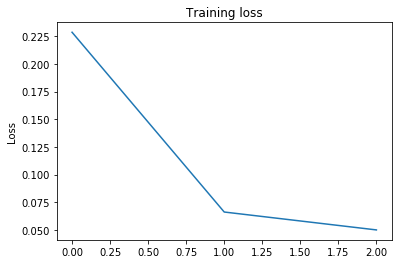

In [8]:
plt.plot(losses)
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()